# Anomalies Extraction Functions

In [ ]:
from scipy.signal import welch
from scipy.stats import zscore
import numpy as np

def eeg_band_anomaly_detector(eeg_df, sampling_rate=128, window_sec=2, clustering_gap=3, alpha_thresh=0.2, beta_thresh=0.2):
    """
    Detects EEG anomalies using both:
    - Local ratio-based suppression (per window, per channel)
    - Global z-score suppression (per subject, per band)
    """
    if 'Timestamp' not in eeg_df.columns:
        raise ValueError("Expected 'Timestamp' column in EEG data.")

    eeg_channels = eeg_df.select_dtypes(include=['number']).columns.difference(['Timestamp'])
    window_size = sampling_rate * window_sec
    total_samples = len(eeg_df)
    num_windows = total_samples // window_size

    # Store all band powers
    band_powers = {ch: {'theta': [], 'alpha': [], 'beta': []} for ch in eeg_channels}
    window_times = []

    for w in range(num_windows):
        start = w * window_size
        end = start + window_size
        segment = eeg_df.iloc[start:end]
        if len(segment) < window_size:
            continue

        mean_time = eeg_df['Timestamp'].iloc[start:end].mean()
        window_times.append(mean_time)

        for ch in eeg_channels:
            freqs, psd = welch(segment[ch], fs=sampling_rate, nperseg=window_size)
            theta = np.trapezoid(psd[(freqs >= 4) & (freqs < 8)])
            alpha = np.trapezoid(psd[(freqs >= 8) & (freqs < 12)])
            beta = np.trapezoid(psd[(freqs >= 13) & (freqs < 30)])

            band_powers[ch]['theta'].append(theta)
            band_powers[ch]['alpha'].append(alpha)
            band_powers[ch]['beta'].append(beta)

    # -------------------------------
    # 1Local ratio-based detection
    # -------------------------------
    anomalies = []
    for ch in eeg_channels:
        for i, time in enumerate(window_times):
            theta = band_powers[ch]['theta'][i]
            alpha = band_powers[ch]['alpha'][i]
            beta = band_powers[ch]['beta'][i]
            total = theta + alpha + beta

            if total == 0:
                continue  # skip empty windows

            alpha_ratio = alpha / total
            beta_ratio = beta / total

            if alpha_ratio < alpha_thresh:
                anomalies.append(f"Low alpha ratio in {ch} at {time:.2f}s (ratio = {alpha_ratio:.2f})")
            if beta_ratio < beta_thresh:
                anomalies.append(f"Low beta ratio in {ch} at {time:.2f}s (ratio = {beta_ratio:.2f})")

    # -------------------------------
    # Z-score suppression detection
    # -------------------------------
    for band in ['alpha', 'beta']:
        band_means = [np.mean(band_powers[ch][band]) for ch in eeg_channels]
        band_zscores = zscore(band_means)

        for ch, z in zip(eeg_channels, band_zscores):
            if z < -1.5:
                label = "Suppressed Alpha" if band == "alpha" else "Suppressed Beta"
                anomalies.append(f"{label} globally in {ch} (z = {z:.2f})")

    return anomalies if anomalies else ["No significant EEG band anomalies detected."]

In [ ]:
def detect_hrv_suppression(hrv_df, suppression_threshold=30):
    """
    Detects HRV suppression using SDNN.
    Prints out SDNN value for inspection.
    """
    if 'Timestamp' not in hrv_df.columns:
        raise ValueError("Expected 'Timestamp' column in HRV data.")

    if 'HR [bpm]' not in hrv_df.columns:
        raise ValueError("Expected 'HR [bpm]' column in HRV data.")

    rr_intervals = 60000 / hrv_df['HR [bpm]']
    sdnn = np.std(rr_intervals)

    print(f"\n[HRV] SDNN = {sdnn:.2f} ms — {'Suppressed' if sdnn < suppression_threshold else 'Normal'}")

    if sdnn < suppression_threshold:
        return f"HRV suppression detected (SDNN = {sdnn:.2f}ms, below {suppression_threshold}ms threshold)."
    else:
        return f"No significant HRV suppression detected (SDNN = {sdnn:.2f}ms)."

In [ ]:
def generate_full_cognitive_summary(eeg_df, hrv_df):
    eeg_anomalies = eeg_band_anomaly_detector(eeg_df)
    hrv_result = detect_hrv_suppression(hrv_df)
    return {
        "EEG Anomalies": eeg_anomalies,
        "HRV Analysis": hrv_result
    }

# LLM Setup

In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def call_llm_api(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a clinical assistant analyzing EEG and HRV patterns for MCI detection."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=700,
        temperature=0.0
    )
    return response.choices[0].message.content


In [ ]:
def parse_llm_output_flexible(text):
    text = str(text).lower()
    if "needs clinical review" in text:
        return "review"
    elif "conclusion: yes" in text:
        return "MCI"
    elif "conclusion: no" in text:
        return "Healthy"
    return "review"

In [ ]:
def build_llm_prompt_with_ontology(eeg_anomalies, hrv_summary_text):
    ontology_reference = """
Ontology Reference:
- Persistent increases in Theta band power and decreases in Alpha band power are associated with Mild Cognitive Impairment (MCI).
- Suppressed Beta activity can suggest cognitive slowing.
- HRV suppression (SDNN < 30 ms) may reflect reduced autonomic flexibility associated with cognitive decline.

Diagnosis Guidance:
A case may be considered consistent with MCI if **either** of the following apply:
  1. At least two features are clearly present:
     - Alpha suppression (especially in multiple frontal/parietal regions)
     - HRV suppression (SDNN < 30 ms)
     - Theta elevation or Beta suppression
  2. A **single strong EEG feature** (e.g., widespread alpha suppression or beta disorganization) is clearly present **along with HRV suppression**

Important:
- Mild or isolated findings — even across two features — should not lead to MCI diagnosis.
- Look for strength, regional consistency, and convergence of features.
- If the evidence is unclear, mild, or partial, defer the case for clinical review.

Numerical summaries such as number of affected channels and average ratio values help assess strength.
"""

    task_instruction = """
Task:
Analyze the EEG and HRV summaries using the ontology above.
Then respond with a final classification in the following format:

Conclusion: [Yes / No / Needs clinical review]
Explanation: [Brief justification for the decision]

Use this logic:
- Respond **"Yes"** if there is strong evidence for MCI under either rule above
- Respond **"No"** if the subject clearly lacks sufficient abnormality
- Respond **"Needs clinical review"** if findings are borderline, ambiguous, or weak
"""

    eeg_summary = sorted(
        [a for a in eeg_anomalies if "alpha" in a.lower() or "beta" in a.lower()],
        key=lambda x: float(re.search(r"ratio\s*=\s*([\d.]+)", x).group(1)) if "ratio =" in x else 1.0
    )[:7]
    eeg_text = "\n".join(eeg_summary)

    return f"{ontology_reference}\n\nEEG Summary:\n{eeg_text}\n\nHRV Summary:\n{hrv_summary_text}\n\n{task_instruction}"


# Classification

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# Paths
EEG_DIR = "data/mci_dataset/EEG"
HRV_DIR = "data/mci_dataset/HRV"

# True labels
TRUE_LABELS = {
    "subject_0_394": 0,
    "subject_0_399": 0,
    "subject_0_462": 0,
    "subject_0_463": 0,
    "subject_0_468": 0,
    "subject_0_475": 0,
    "subject_0_476": 0,
    "subject_1_397": 1,
    "subject_1_455": 1,
    "subject_1_456": 1,
    "subject_1_457": 1,
    "subject_1_459": 1,
    "subject_1_461": 1,
    "subject_1_464": 1,
    "subject_1_467": 1
}

In [ ]:
all_llm_results = []

for subject_id, condition in tqdm(TRUE_LABELS.items()):
    eeg_file = os.path.join(EEG_DIR, f"{subject_id}_with_timestamp.csv")
    hrv_file = os.path.join(HRV_DIR, f"{subject_id}_HRV_with_timestamp.csv")

    try:
        eeg_df = pd.read_csv(eeg_file)
        hrv_df = pd.read_csv(hrv_file)

        # Run anomaly detection
        eeg_anomalies = eeg_band_anomaly_detector(eeg_df)
        hrv_summary_text = detect_hrv_suppression(hrv_df)

        # Build LLM prompt
        prompt = build_llm_prompt_with_ontology(eeg_anomalies, hrv_summary_text)

        # Call the LLM
        llm_response = call_llm_api(prompt)

        # Parse LLM output (THIS IS WHERE YOU USE IT)
        parsed_decision = parse_llm_output_flexible(llm_response)

        # Store result
        all_llm_results.append({
            "Subject": subject_id,
            "Subject Condition": "MCI" if condition == 1 else "Healthy",
            "LLM Output": llm_response,
            "LLM Decision": parsed_decision
        })

    except Exception as e:
        print(f"Error with {subject_id}: {e}")
        all_llm_results.append({
            "Subject": subject_id,
            "Subject Condition": "MCI" if condition == 1 else "Healthy",
            "LLM Output": f"Exception: {e}",
            "LLM Decision": "error"
        })

  0%|          | 0/15 [00:00<?, ?it/s]


[HRV] SDNN = 60.74 ms — Normal


  7%|▋         | 1/15 [00:05<01:17,  5.52s/it]


[HRV] SDNN = 54.35 ms — Normal


 13%|█▎        | 2/15 [00:10<01:09,  5.38s/it]


[HRV] SDNN = 70.78 ms — Normal


 20%|██        | 3/15 [00:15<01:02,  5.24s/it]


[HRV] SDNN = 28.49 ms — Suppressed


 27%|██▋       | 4/15 [00:19<00:50,  4.60s/it]


[HRV] SDNN = 65.70 ms — Normal


 33%|███▎      | 5/15 [00:24<00:47,  4.78s/it]


[HRV] SDNN = 34.49 ms — Normal


 40%|████      | 6/15 [00:30<00:46,  5.16s/it]


[HRV] SDNN = 36.61 ms — Normal


 47%|████▋     | 7/15 [00:34<00:38,  4.78s/it]


[HRV] SDNN = 41.39 ms — Normal


 53%|█████▎    | 8/15 [00:39<00:34,  4.98s/it]


[HRV] SDNN = 23.77 ms — Suppressed


 60%|██████    | 9/15 [00:44<00:28,  4.80s/it]


[HRV] SDNN = 20.55 ms — Suppressed


 67%|██████▋   | 10/15 [00:48<00:23,  4.64s/it]


[HRV] SDNN = 25.03 ms — Suppressed


 73%|███████▎  | 11/15 [00:52<00:18,  4.51s/it]


[HRV] SDNN = 28.56 ms — Suppressed


 80%|████████  | 12/15 [00:57<00:13,  4.54s/it]


[HRV] SDNN = 24.81 ms — Suppressed


 87%|████████▋ | 13/15 [01:02<00:09,  4.61s/it]


[HRV] SDNN = 27.69 ms — Suppressed


 93%|█████████▎| 14/15 [01:06<00:04,  4.38s/it]


[HRV] SDNN = 27.87 ms — Suppressed


100%|██████████| 15/15 [01:10<00:00,  4.72s/it]


In [ ]:
# Save results + accuracy
results_df = pd.DataFrame(all_llm_results)
results_df.to_csv("llm_subject_predictions_eeg_hrv.csv", index=False)

In [ ]:
results_df

,Subject,Subject Condition,LLM Output,LLM Decision
0,subject_0_394,Healthy,Conclusion: No \nExplanation: The EEG summary...,Healthy
1,subject_0_399,Healthy,Conclusion: No \nExplanation: The EEG summary...,Healthy
2,subject_0_462,Healthy,Conclusion: No\n\nExplanation: The EEG summary...,Healthy
3,subject_0_463,Healthy,Conclusion: Yes \nExplanation: The case prese...,MCI
4,subject_0_468,Healthy,Conclusion: No \nExplanation: The EEG summary...,Healthy
5,subject_0_475,Healthy,Conclusion: Needs clinical review\n\nExplanati...,review
6,subject_0_476,Healthy,Conclusion: No\n\nExplanation: The EEG summary...,Healthy
7,subject_1_397,MCI,Conclusion: Needs clinical review\n\nExplanati...,review
8,subject_1_455,MCI,Conclusion: Yes \nExplanation: The case shows...,MCI
9,subject_1_456,MCI,Conclusion: Yes \nExplanation: The case shows...,MCI


In [ ]:
import re

def categorize_llm_response(llm_output):
    text = llm_output.lower()

    # Try to extract explicit label
    if "conclusion:" in text:
        match = re.search(r"conclusion:\s*(yes|no)", text)
        if match:
            decision = "mci" if match.group(1) == "yes" else "healthy"
        else:
            decision = "uncertain"
    elif "mci" in text:
        if "consistent with mci" in text or "supports diagnosis of mci" in text:
            decision = "mci"
        elif "not consistent" in text or "evidence is insufficient" in text:
            decision = "healthy"
        else:
            decision = "uncertain"
    else:
        decision = "uncertain"

    # Now determine confidence
    if any(phrase in text for phrase in [
        "clearly consistent", "strong evidence", "clear indication", "meets multiple criteria"
    ]):
        confidence = "confident"
    elif any(phrase in text for phrase in [
        "partially consistent", "borderline", "leaning", "some indication", "not conclusive"
    ]):
        confidence = "borderline"
    else:
        confidence = "confident" if decision != "uncertain" else "inconclusive"

    return {"decision": decision, "confidence": confidence}


In [ ]:
for entry in all_llm_results:
    parsed = categorize_llm_response(entry["LLM Output"])
    entry["LLM Decision"] = parsed["decision"]
    entry["Confidence"] = parsed["confidence"]

In [ ]:
all_llm_results

[{'Subject': 'subject_0_394',
  'Subject Condition': 'Healthy',
  'LLM Output': 'Conclusion: No  \nExplanation: The EEG summary shows low alpha ratios in several channels, indicating some level of alpha suppression. However, the HRV summary does not show significant suppression (SDNN = 60.74ms), which is above the threshold for concern. Since there is no HRV suppression and only one EEG feature (alpha suppression) without widespread or strong evidence across multiple regions, the criteria for MCI are not met. Therefore, the subject lacks sufficient abnormality for an MCI diagnosis.',
  'LLM Decision': 'healthy',
  'Confidence': 'confident'},
 {'Subject': 'subject_0_399',
  'Subject Condition': 'Healthy',
  'LLM Output': 'Conclusion: No  \nExplanation: The EEG summary indicates low alpha ratios in multiple frontal and parietal regions, suggesting alpha suppression. However, the HRV summary shows no significant suppression (SDNN = 54.35ms), which does not meet the criteria for HRV suppre

# Results

In [ ]:
from collections import Counter

Counter((entry["Subject Condition"], entry["LLM Decision"], entry["Confidence"]) for entry in all_llm_results)

Counter({('Healthy', 'healthy', 'confident'): 5,
         ('Healthy', 'mci', 'confident'): 1,
         ('Healthy', 'uncertain', 'borderline'): 1,
         ('MCI', 'uncertain', 'borderline'): 1,
         ('MCI', 'mci', 'confident'): 7})

## Confusion Matrix

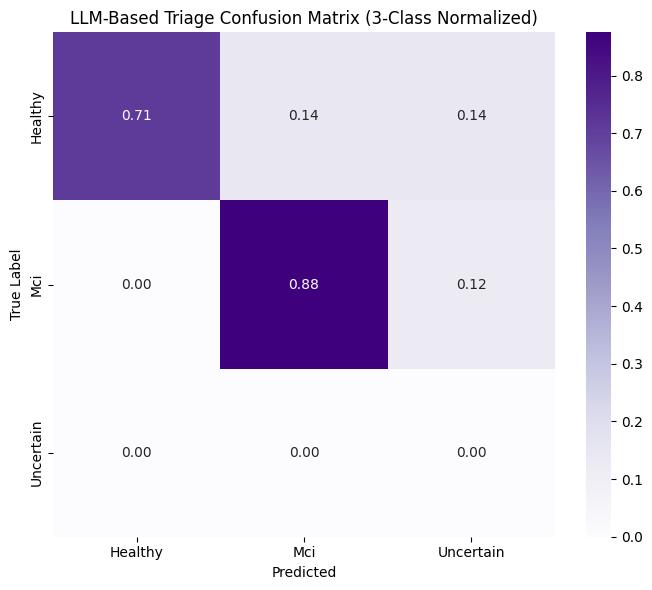

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load your results file
df = pd.read_csv("llm_subject_predictions_eeg_hrv.csv")

# Normalize labels
df["Subject Condition"] = df["Subject Condition"].str.strip().str.capitalize()
df["LLM Decision"] = df["LLM Decision"].replace("review", "Uncertain").str.strip().str.capitalize()

# Define labels and compute confusion matrix
labels = ["Healthy", "Mci", "Uncertain"]
y_true = df["Subject Condition"]
y_pred = df["LLM Decision"]

# 1. Normalized Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Purples", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("LLM-Based Triage Confusion Matrix (3-Class Normalized)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

overall_acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {overall_acc:.2f}")

Overall Accuracy: 0.80


## Classification Report

In [ ]:
# 2. Classification Report (Healthy vs MCI only)
binary_report = classification_report(
    y_true, y_pred, labels=["Healthy", "Mci"], output_dict=True, zero_division=0
)
binary_df = pd.DataFrame(binary_report).transpose()
display(binary_df)

,precision,recall,f1-score,support
Healthy,1.000000,0.714286,0.833333,7.0
Mci,0.875000,0.875000,0.875000,8.0
micro avg,0.923077,0.800000,0.857143,15.0
macro avg,0.937500,0.794643,0.854167,15.0
weighted avg,0.933333,0.800000,0.855556,15.0


## Decision Distribution Chart

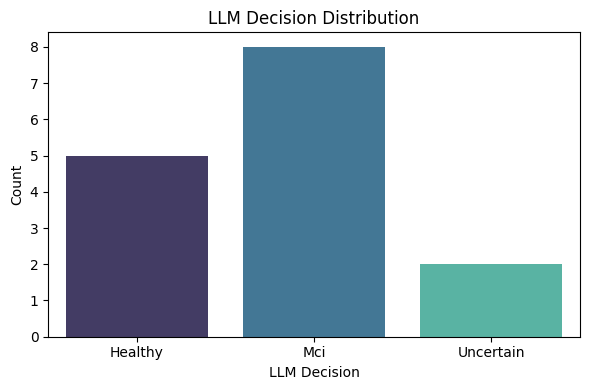

In [ ]:
# 3. Decision Distribution Chart
decision_counts = df["LLM Decision"].value_counts().reindex(labels, fill_value=0)

plt.figure(figsize=(6, 4))
sns.barplot(
    x=decision_counts.index,
    y=decision_counts.values,
    hue=decision_counts.index,
    palette="mako",
    legend=False
)
plt.ylabel("Count")
plt.title("LLM Decision Distribution")
plt.tight_layout()
plt.show()
